<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [51]:
import pandas as pd 
import numpy as np 

from sklearn.pipeline import Pipeline

import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier 
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import time
import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

import plotly.graph_objects as go


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [61]:
df.info

<bound method DataFrame.info of                                                      text  toxic
0       Explanation\nWhy the edits made under my usern...      0
1       D'aww! He matches this background colour I'm s...      0
2       Hey man, I'm really not trying to edit war. It...      0
3       "\nMore\nI can't make any real suggestions on ...      0
4       You, sir, are my hero. Any chance you remember...      0
...                                                   ...    ...
159566  ":::::And for the second time of asking, when ...      0
159567  You should be ashamed of yourself \n\nThat is ...      0
159568  Spitzer \n\nUmm, theres no actual article for ...      0
159569  And it looks like it was actually you who put ...      0
159570  "\nAnd ... I really don't think you understand...      0

[159571 rows x 2 columns]>

In [62]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [63]:
df.tail()

,text,toxic
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0
159570,"""\nAnd ... I really don't think you understand...",0


In [64]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

In [65]:
#пропуски
print(df.isnull().sum())

text     0
toxic    0
dtype: int64


In [66]:
#дубликаты
print(df.duplicated().sum())

0


Text(0.5, 1.0, 'Целевой признак')

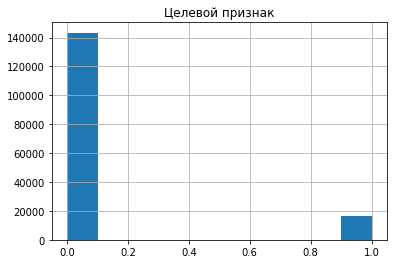

In [67]:
# Смотрю как распределен целевой признак
df['toxic'].hist()
plt.title('Целевой признак')

В представленном датасете 159571 строк и 2 столбца. Текст сырой, его необходимо будет очистить и ламметизировать. Пропущенных значений нет. Целевым признаком является ['toxic']-оценка токсичности в комментарии ['text']

Присутствует сильный дисбаланс классов.

## Обучение

In [10]:
# Очищаем текст. Лемматизируем c использованием WordNetLemmatizer. Приводим к нижнему регистру.

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    clean = " ".join(re.sub(r'[^a-zA-z]', ' ', text).lower().split())
    word_list = nltk.word_tokenize(clean)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])    
    return lemmatized_output

df['lemmatize'] = df['text'].apply(clean_text)

In [11]:
display(df)

,text,toxic,lemmatize
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,and for the second time of asking when your vi...
159567,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that is a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there no actual article for prosti...
159569,And it looks like it was actually you who put ...,0,and it look like it wa actually you who put on...


In [22]:
X = df.drop('toxic', axis=1)#выделяем признаки
y = df['toxic']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=12345)
#делим на выборки

In [14]:
#LogisticRegression
%%time

lr_pipe = Pipeline([#обучаем с балансировкой классов при помощи Pipeline
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),
    ('clf', LogisticRegression(random_state=12345))])

params = {'clf__C': [0.1, 1, 10, 100],
          'clf__class_weight': ['balanced', None]}

lr_grid = GridSearchCV(estimator=lr_pipe, param_grid=params, cv=3, scoring='f1', n_jobs=-1,\
                       refit=False)#подбираем параметры
lr_grid.fit(X_train['text'], y_train)
lr_best_paramms = lr_grid.best_params_

print(lr_best_paramms)
print(lr_grid.best_score_)

{'clf__C': 10, 'clf__class_weight': 'balanced'}
0.7732424329449078
CPU times: user 14min 2s, sys: 8min 38s, total: 22min 40s
Wall time: 22min 42s


In [15]:
#LGBMClassifier
%%time

lgb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),
    ('clf', LGBMClassifier(random_state=12345))])

params = {
  'clf__n_estimators': [200],
  'clf__learning_rate': [0.15, 0.25],
  'clf__max_depth': [8, 10, -1]}

lgb_grid = GridSearchCV(estimator=lgb_pipe, param_grid=params, cv=3, scoring='f1', n_jobs=-1, refit=False)
lgb_grid.fit(X_train['text'], y_train)
lgb_best_params = lgb_grid.best_params_

print(lgb_best_params)
print(lgb_grid.best_score_)

{'clf__learning_rate': 0.15, 'clf__max_depth': -1, 'clf__n_estimators': 200}
0.7677571478667092
CPU times: user 4h 13min 11s, sys: 1min 16s, total: 4h 14min 28s
Wall time: 4h 15min 43s


In [24]:
vectorize = TfidfVectorizer(ngram_range=(1,3),
               min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)

In [25]:
X_train = vectorize.fit_transform(X_train['text'])#преобразуем в векторы
X_test = vectorize.transform(X_test['text'])

In [26]:
lr_m = LogisticRegression(C=10, class_weight='balanced', random_state=12345)
lr_m.fit(X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', random_state=12345)

In [27]:
LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(C=10, class_weight='balanced', multi_class='warn',
                   random_state=12345, solver='warn')

In [28]:
lgb_m = LGBMClassifier(learning_rate=0.25, max_depth=-1, n_estimators=200, random_state = 12345)
lgb_m.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.25, n_estimators=200, random_state=12345)

In [29]:
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.25, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(learning_rate=0.25, n_estimators=200, random_state=12345,
               silent=True)

In [30]:
def scoring(fitted_model):
    test_pred = fitted_model.predict(X_test)
    test_f1 = f1_score(y_test, test_pred)
    
    print('F1 on test: {:.3f}'.format(test_f1))

## Выводы

In [47]:
scoring(lr_m)

F1 on test: 0.784


In [48]:
scoring(lgb_m)

F1 on test: 0.777


Логистическая регрессия выдает результат F1-score: 0.784 на тестовой выборке, это лучший результат. LGBMClassifier показывает результат 0.777 и значительно уступает Логистической регрессии по времени обучения